<a href="https://colab.research.google.com/github/kevindmzapata/deep-learning-project/blob/main/02_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 - Arquitectura de Linea de Base

## I. Importar librerias necesarias

In [1]:
!wget -nc --no-cache -O database.zip -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/database.zip
!unzip -n -q database.zip
!rm database.zip
!wget -nc --no-cache -O utils.py -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/resources/utils.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from utils import load_data, plot_regression_history, plot_classification_history

## II. Cargar imagenes de la base de datos

In [3]:
X, y, x_extra = load_data("database")

In [4]:
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

In [5]:
print("Las dimensiones de la base de datos son: ", X.shape, y.shape, x_extra.shape)

Las dimensiones de la base de datos son:  (729, 4096) (729, 1) (729, 8)


In [6]:
X_train, X_test, y_train, y_test, x_extra_train, x_extra_test = train_test_split(
    X, y, x_extra, test_size=0.1, random_state=0)

In [7]:
epsilon = 1e-17
X_train = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0) + epsilon)
X_test = (X_test - X_test.mean(axis=0)) / (X_test.std(axis=0) + epsilon)

y_train = (y_train - y_train.mean(axis=0)) / (y_train.std(axis=0) + epsilon)
y_test = (y_test - y_test.mean(axis=0)) / (y_test.std(axis=0) + epsilon)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, x_extra_train.shape, x_extra_test.shape

((656, 4096), (73, 4096), (656, 1), (73, 1), (656, 8), (73, 8))

In [9]:
y_train.mean(), y_train.std(), y_test.mean(), y_test.std()

(2.4912321528174247e-16, 1.0, 2.448574068008907e-16, 0.9999999999999999)

## III. Generar modelo de regresión y entrenar

In [10]:
def create_model(input_dim, output_dim, mode="regression", regularizer=True, extra_dim=(False, 0), activation="relu"):
  from tensorflow.keras.models import Model
  from tensorflow.keras.layers import Input, Dense, concatenate
  from tensorflow.keras.optimizers import SGD
  from tensorflow.keras.regularizers import l1_l2

  sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

  input_0 = Input(shape=(input_dim,), name="input_0")

  if regularizer:
    x = Dense(32, activation=activation, kernel_regularizer=l1_l2(0.001, 0.001), name="dense_0")(input_0)
    x = Dense(16, activation=activation, kernel_regularizer=l1_l2(0.01, 0.01), name="dense_1")(x)
  else:
    x = Dense(32, activation=activation, name="dense_0")(input_0)
    x = Dense(16, activation=activation, name="dense_1")(x)

  if extra_dim[0]:
    input_1 = Input(shape=(extra_dim[1],), name="input_1")
    x = concatenate([x, input_1], name="concat_0")
    input = [input_0, input_1]
  else:
    input = input_0

  if mode == "classification":
    if output_dim > 2:
      out_0 = Dense(output_dim, activation="softmax", name="out_0")(x)
      model = Model(inputs=input, outputs=out_0)
      model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    else:
      out_0 = Dense(1, activation="sigmoid", name="out_0")(x)
      model = Model(inputs=input, outputs=out_0)
      model.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["accuracy"])
  elif mode == "regression":
    out_0 = Dense(1, activation="linear", name="out_0")(x)
    model = Model(inputs=input, outputs=out_0)
    model.compile(optimizer="adam", loss="mean_squared_error")
  else:
    raise ValueError("Invalid mode")

  return model

In [11]:
create_model(X_train.shape[1],
             y_train.shape[1],
             mode="regression",
             regularizer=True,
             extra_dim=(True, x_extra_train.shape[1])
             ).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_0 (InputLayer)      │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 32)             │        131,104 │ input_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dense_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_0 (Concatenate)    │ (None, 24)             │              0 │ dense_1[0][0],         │
│                           │                        │                │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_0 (Dense)             │ (None, 1)              │             25 │ concat_0[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 131,657 (514.29 KB)

 Trainable params: 131,657 (514.29 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def plot_learning_curve(epochs=100, batch_size=16, regularizer=True, extra_dim=(True, x_extra_train.shape[1])):
  from tensorflow.keras.metrics import RootMeanSquaredError

  nb_samples = [10, 50, 100, 200, 300, 600]
  losses = []

  for value in nb_samples:
    model = create_model(X_train.shape[1],
                        y_train.shape[1],
                        mode="regression",
                        regularizer=regularizer,
                        extra_dim=extra_dim,
                        activation="relu",
                        )
    input = [X_train[:value], x_extra_train[:value]]
    output = y_train[:value]
    model.fit(input, output, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict([X_test, x_extra_test], verbose=0)
    loss = RootMeanSquaredError()
    loss.update_state(y_test, preds)
    losses.append(loss.result().numpy())

  plt.figure(figsize=(8, 6))
  plt.plot(nb_samples, losses)
  plt.xlabel("Número de muestras de entrenamiento")
  plt.ylabel("Raiz del error cuadrático medio")
  plt.title("Curva de aprendizaje")
  plt.show()

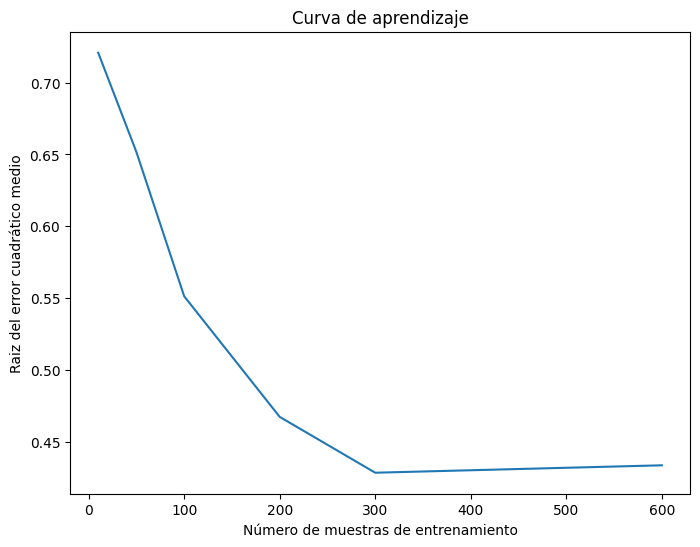

In [13]:
plot_learning_curve()

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
mode = "regression"
model = create_model(X_train.shape[1], y_train.shape[1], mode=mode, regularizer=True, extra_dim=(True, x_extra_train.shape[1]), activation="relu")
input_train = [X_train, x_extra_train]
input_test = [X_test, x_extra_test]
history = model.fit(input_train, y_train, epochs=500, batch_size=16, validation_data=(input_test, y_test), callbacks=[early_stopping], verbose=0)

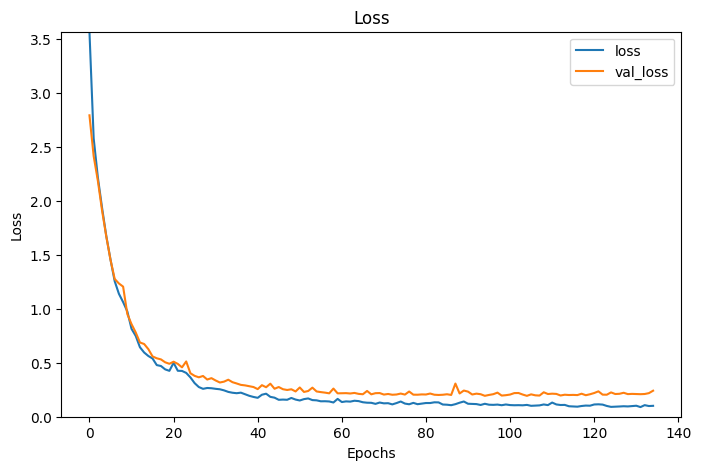

Final loss: 0.24 dB


In [15]:
if mode == "classification":
    plot_classification_history(history)
elif mode == "regression":
    plot_regression_history(history)